In [1]:
#!pip install finance-datareader

In [2]:
#!pip install plotly

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

import torch
import torch.nn as nn

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
#https://github.com/FinanceData/FinanceDataReader
data = fdr.DataReader("005930")      # 삼성전자 전체 (1999년 ~ 현재)
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-04-21,6060,6180,5970,6050,528513,NaN
2000-04-24,5970,6030,5760,5800,556613,-0.041322
2000-04-25,5620,5760,5520,5640,698014,-0.027586
2000-04-26,5820,5860,5600,5600,785860,-0.007092
2000-04-27,5520,5700,5400,5400,1082253,-0.035714


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 2000-04-21 to 2024-08-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [7]:
#dataframe형태의 데이터야 함
#<class 'pandas.core.frame.DataFrame'>
data=data[["Close"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 2000-04-21 to 2024-08-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   6000 non-null   int64
dtypes: int64(1)
memory usage: 93.8 KB


In [8]:
#<class 'pandas.core.series.Series'>
data2=data["Close"]
data2.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 6000 entries, 2000-04-21 to 2024-08-09
Series name: Close
Non-Null Count  Dtype
--------------  -----
6000 non-null   int64
dtypes: int64(1)
memory usage: 93.8 KB


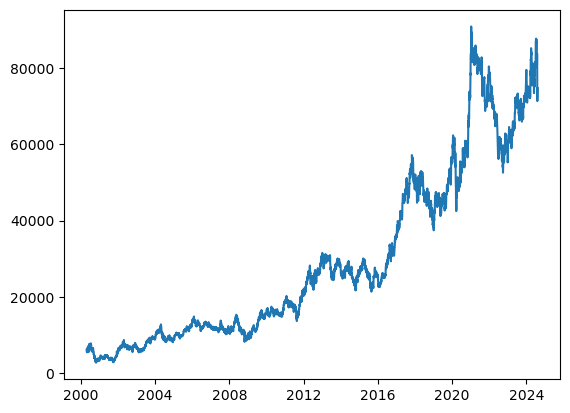

In [9]:
plt.plot(data)

### 딥러닝 전용으로 코드 작성
-close 추세를 반영해서 close값 예측

lstm은 추세를 따라가지 않는다. <br />
추세를 따라가야할 때, 조작적 정의를 통한 파생데이터가 필요하다. <br /> 
shift() , pct_change(), diff(), rolling(), resample()<br /> 

In [10]:
from copy import deepcopy as dc

def prepare_dateframe_for_lstm(df, n_steps):
    df=dc(df)
    for i in range(1, n_steps+1):
        df[f"Close(t-{i})"]=df["Close"].shift(i)
    df.dropna(inplace=True)
    return df

lookback=7
shifted_df=prepare_dateframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-05-03,6180,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0,6050.0
2000-05-04,6180,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0,5800.0
2000-05-08,6560,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0,5640.0
2000-05-09,6370,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0,5600.0
2000-05-10,6350,6370.0,6560.0,6180.0,6180.0,6280.0,6000.0,5400.0
...,...,...,...,...,...,...,...,...
2024-08-05,71400,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0,80400.0
2024-08-06,72500,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0,80900.0
2024-08-07,74700,72500.0,71400.0,79600.0,83100.0,83900.0,81000.0,81200.0


In [11]:
#pandas데이터를 numpy데이터로 변환
shifted_df_as_np=shifted_df.to_numpy()
shifted_df_as_np.shape #(5993, 8)
shifted_df_as_np

array([[ 6180.,  6280.,  6000., ...,  5640.,  5800.,  6050.],
       [ 6180.,  6180.,  6280., ...,  5600.,  5640.,  5800.],
       [ 6560.,  6180.,  6180., ...,  5400.,  5600.,  5640.],
       ...,
       [74700., 72500., 71400., ..., 83900., 81000., 81200.],
       [73400., 74700., 72500., ..., 83100., 83900., 81000.],
       [74800., 73400., 74700., ..., 79600., 83100., 83900.]])

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np=scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np[0]

array([-0.92183075, -0.91956497, -0.92590914, -0.9395038 , -0.93497224,
       -0.93406593, -0.93044069, -0.92477625])

In [13]:
X=shifted_df_as_np[:,1:]   #Close(t-1)	Close(t-2)	Close(t-3)	Close(t-4)	Close(t-5)	Close(t-6)	Close(t-7)
y=shifted_df_as_np[:,0]    #Close
print(X.shape, y.shape) 

(5993, 7) (5993,)


In [14]:
X[0]

array([-0.91956497, -0.92590914, -0.9395038 , -0.93497224, -0.93406593,
       -0.93044069, -0.92477625])

In [15]:
X=dc(np.flip(X, axis=1))
X


array([[-0.92477625, -0.93044069, -0.93406593, ..., -0.9395038 ,
        -0.92590914, -0.91956497],
       [-0.93044069, -0.93406593, -0.93497224, ..., -0.92590914,
        -0.91956497, -0.92183075],
       [-0.93406593, -0.93497224, -0.9395038 , ..., -0.91956497,
        -0.92183075, -0.92183075],
       ...,
       [ 0.777954  ,  0.77342245,  0.83912994, ...,  0.7417016 ,
         0.55590801,  0.58083154],
       [ 0.77342245,  0.83912994,  0.82100374, ...,  0.55590801,
         0.58083154,  0.6306786 ],
       [ 0.83912994,  0.82100374,  0.7417016 , ...,  0.58083154,
         0.6306786 ,  0.60122352]])

In [16]:
split_index = int(len(X) * 0.95)
split_index

#split_index는 데이터셋을 훈련 세트와 검증(또는 테스트) 세트로 나누기 위해 사용하는 인덱스입니다. 
#주어진 코드에서는 전체 데이터의 95%를 훈련 세트로 사용하고 나머지 5%를 검증(또는 테스트) 세트로 사용하는 것으로 보입니다.

5693

### train test
batch_first =True

In [17]:
X_train=X[:split_index]
X_test=X[split_index:]
y_train=y[:split_index]
y_test=y[split_index:]

X_train=X_train.reshape((-1, lookback, 1))
X_test=X_test.reshape((-1, lookback, 1))
y_train=y_train.reshape((-1,  1))
y_test=y_test.reshape((-1,  1))

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5693, 7, 1) (300, 7, 1) (5693, 1) (300, 1)


In [19]:
X_train=torch.tensor(X_train).float()
X_test=torch.tensor(X_test).float()
y_train=torch.tensor(y_train).float()
y_test=torch.tensor(y_test).float()

In [20]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([5693, 7, 1]) torch.Size([300, 7, 1]) torch.Size([5693, 1]) torch.Size([300, 1])


In [21]:
# 데이터 셋
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X=X
        self.y=y
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset=TimeSeriesDataset(X_train, y_train)
test_dataset=TimeSeriesDataset(X_test, y_test)

In [23]:
# 데이터 loader
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)   
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


torch.Size([16, 7, 1]) <br />
16은 배치 크기로, 한 번의 학습 과정에서 모델에 전달되는 샘플의 수입니다.<br />
7은 시퀀스 길이로, 각 샘플이 7개의 시간 스텝(또는 시퀀스)을 포함한다는 것을 의미합니다. 이는 시계열 데이터 또는 RNN 모델에 적합한 형태입니다.<br />
1은 특성 수로, 각 시퀀스 단계에서 하나의 특성을 가지는 것을 의미합니다. 즉, 각 시간 스텝마다 1개의 값이 있다는 뜻입니다.<br />
torch.Size([16, 1])<br />
이 텐서의 형태는 (배치 크기, 타겟 변수 수)를 나타냅니다.<br />
16은 배치 크기로, 타겟 데이터에서도 동일하게 16개의 샘플이 포함되어 있습니다.<br />
1은 타겟 변수 수로, 각 샘플에 대해 1개의 타겟 값이 있다는 것을 의미합니다.<br />

In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)        
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [26]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [27]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [28]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.221
Batch 200, Loss: 0.115
Batch 300, Loss: 0.031

Val Loss: 0.117
***************************************************

Epoch: 2
Batch 100, Loss: 0.010
Batch 200, Loss: 0.007
Batch 300, Loss: 0.005

Val Loss: 0.023
***************************************************

Epoch: 3
Batch 100, Loss: 0.004
Batch 200, Loss: 0.003
Batch 300, Loss: 0.002

Val Loss: 0.009
***************************************************

Epoch: 4
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.003
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.002
*****************

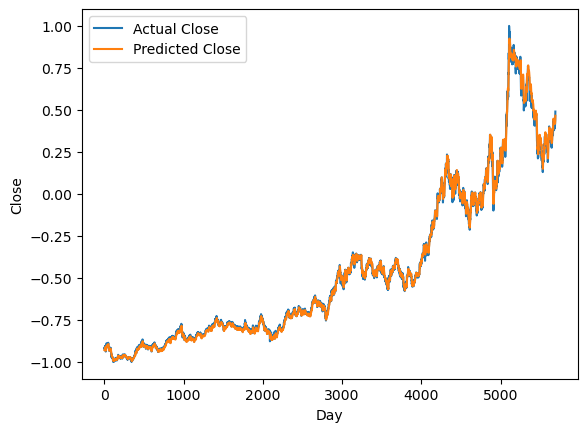

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()  #추세를 따라가지만 과대적합이다.

## train Predictions

In [30]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 5816.0850817 ,  5873.38592172,  5930.0554055 , ...,
       65727.80807212, 66225.40096954, 67399.07643452])

In [31]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 6179.99881804,  6179.99881804,  6559.99898523, ...,
       66199.99940351, 68399.99967918, 68499.99993086])

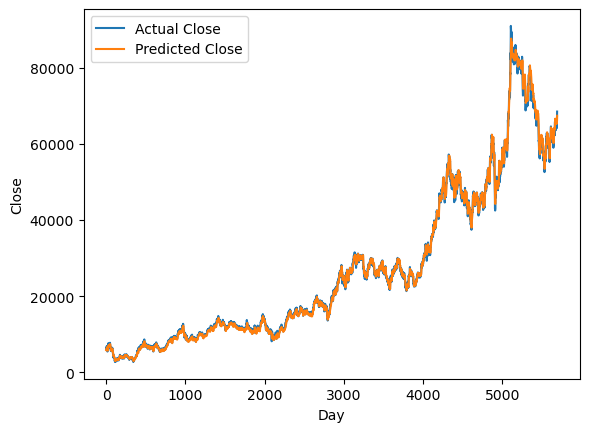

In [32]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

## Test Predictions

In [33]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([68242.57889286, 68742.61040375, 69092.66981661, 69411.76252127,
       70157.67308891, 71351.63087308, 71833.50300014, 71945.47402918,
       72455.49412191, 72650.13072789, 72506.44983172, 72333.40560913,
       72561.10423684, 72413.94562006, 72632.4948436 , 72757.49285638,
       72705.8216095 , 72774.61839437, 72626.88103437, 72558.91027391,
       72229.30022657, 72242.5744915 , 72382.6513958 , 72757.63491154,
       73091.02783501, 73359.5489049 , 73436.97422504, 73425.27835071,
       73662.78930664, 73834.4129777 , 73596.70735359, 73274.64727461,
       72470.36256135, 71749.82199192, 71962.57852197, 72283.06547165,
       72502.22500622, 73176.57134414, 73640.43403447, 73530.15188336,
       73324.17717159, 72908.19232941, 72357.96010554, 72006.48408711,
       71617.00568438, 71284.69658911, 71747.77008414, 71735.03247201,
       71423.77384603, 71668.5243535 , 71448.86499524, 70879.53424513,
       70304.61599231, 69958.06981385, 69431.69759452, 69545.31541109,
      

In [34]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([68399.99967918, 68499.99993086, 68799.99937057, 70299.99919981,
       72299.99897212, 71400.00065297, 70900.00070989, 72200.00003576,
       71700.00009269, 70999.99964625, 70900.00070989, 71999.9995324 ,
       70999.99964625, 71999.9995324 , 71900.00059605, 71499.99958932,
       71799.99902904, 71200.00014961, 71400.00065297, 70499.99970317,
       71299.99908596, 71600.00115633, 72400.00053912, 72600.00104249,
       72699.99997884, 72400.00053912, 72200.00003576, 72999.99941856,
       72999.99941856, 71999.9995324 , 71600.00115633, 69900.00082374,
       69499.99981701, 71499.99958932, 71900.00059605, 71900.00059605,
       73400.00042528, 73299.99885827, 71999.9995324 , 71700.00009269,
       70999.99964625, 70299.99919981, 70400.00076681, 69999.99976009,
       69799.99925673, 71700.00009269, 70600.00127017, 69799.99925673,
       71100.00121325, 69900.00082374, 68799.99937057, 68299.9994275 ,
       68499.99993086, 67600.00029638, 68899.99962226, 67999.99998778,
      

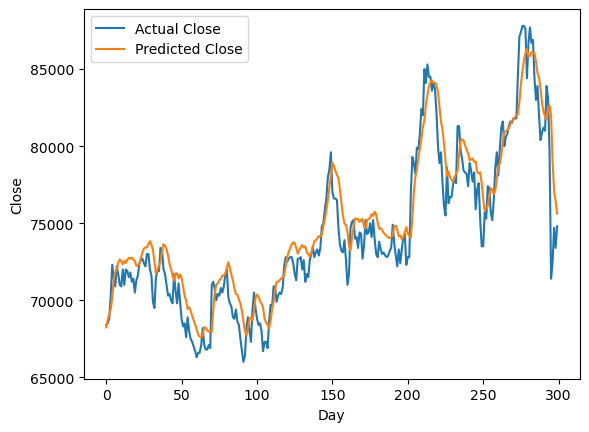

In [35]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()